In [49]:
import numpy as np
import pandas as pd

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
import datetime
from scipy import stats


In [50]:
import warnings

In [51]:
warnings.filterwarnings("ignore")

In [52]:
import matplotlib as mpl
mpl.rc('font',family='Times New Roman')

tbfont = {'fontname': 'Times New Roman Bold'}
tfont = {'fontname':'Times New Roman'}

mpl.rc('text', usetex=True)

In [53]:
gram = pd.read_excel('scores_data.xlsx')
print(gram)

      Actual Score  Estimated Score
0               12         8.138708
1               10         9.775385
2               12         8.323084
3               15         4.868079
4                9        10.040981
...            ...              ...
1995            14         6.668646
1996            10         9.003929
1997             7        12.365193
1998            10         9.965765
1999             8        11.928045

[2000 rows x 2 columns]


In [54]:
# gram = pd.read_excel('.csv', encoding = 'utf-8')


gram['score'] = gram['Actual Score'].astype(float)
gram['guess'] = gram['Estimated Score'].astype(float)
len(gram)

2000

Model Training Starts

In [55]:
# bayesian inference model with guessing parameter (g=0.2)
preds_guess = pd.read_csv('output_file.csv', encoding = "utf-8")

In [56]:
lb = preds_guess.shape[1]

In [57]:
ssesG = []

for i in range(lb): # first loop through each simulated set of values
    pred = preds_guess[str(i)]
    # print(pred)
    sse = 0
    for s,gs in zip(gram['score'],gram['guess']):

        # take the sth prediction which means if they got 3 correct, it would compare to the simulation for 3 correct
        # (pred[s] - gs)

        sse = sse + (pred[s-1] - gs)**2

    ssesG.append(sse)
# ssesG

In [58]:
ssesG_ind = ssesG.index(min(ssesG));
print('min sse: ', min(ssesG))
print('index: ', ssesG.index(min(ssesG)))

min sse:  33988.56072499129
index:  2


In [59]:
epsilons = np.linspace(0,0.5,num=3)
muts = np.linspace(0,1,num=5)

preds_ind = []
for mut in muts: # loop through mu thetas
    for eps in epsilons: # loop through epsilons
        preds_ind.append(('eps: ', eps,'mu: ', mut))

In [60]:
# ssesG_ind = 7;
preds_ind[ssesG_ind]

# preds_ind[7]


('eps: ', 0.5, 'mu: ', 0.0)

In [61]:
# performance-dependent estimation model with guessing
preds_dk_guess = pd.read_csv('eps_output_file.csv', encoding = "utf-8")

In [62]:
lg = preds_dk_guess.shape[1]
lg

27

In [63]:
ssesGdk = []
for i in range(lg): # first loop through each simulated set of values
    pred = preds_dk_guess[str(i)]
#     print(pred)
    sse = 0
    for s,guess in zip(gram['score'],gram['guess']):

        # take the sth prediction which means if they got 3 correct, it would compare to the simulation for 3 correct
        error = abs(pred[s-1] - guess)
        sse += error**2
    ssesGdk.append(sse)
# ssesGdk

In [64]:
ssesGdk_ind = ssesGdk.index(min(ssesGdk));
print('min sse: ', min(ssesGdk))
print('index: ', ssesGdk.index(min(ssesGdk)))

min sse:  37180.84795063139
index:  6


In [65]:
epsilons = np.linspace(0,0.5,num=2)
alphas = np.linspace(0,0.5,2)
muts = np.linspace(0,1,num=3)

preds_dep = []
for mut in muts: # loop through mu thetas
    for eps0 in epsilons: # loop through epsilon intercepts
        for alph in alphas: # loop through epsilon slopes
            preds_dep.append(('mu: ', mut, 'eps: ', eps0, 'alpha: ', alph))

In [66]:
# ssesGdk_ind = 7
preds_dep[ssesGdk_ind]

('mu: ', 0.5, 'eps: ', 0.5, 'alpha: ', 0.0)

### Finding the BICs and doing a likelihood ratio test



These models are nested, so we can do a likelihood ratio test. The test statistic is $2*(L_1-L_0)$, where $L_1$ and $L_0$ are the log likelihoods of the more complex and simpler models respectively. The statistic is approximately chi-square with df 1, for a cutoff of 3.84.

In [67]:
from scipy.stats import chi2
def likelihood_ratio(llmin, llmax):
    return(2*(llmax-llmin))

In [68]:
k0 = 3 # bayesian inference model has 3 params (mu, sigma, eps)
k1 = 4 # performance-dependent estimation model has 4 (mu, sigma, eps0, alpha)
n = 2000 # total participants
s0 = min(ssesG) # sse for ind model
s1 = min(ssesGdk) # sse for dep model

L0 = -n/2 *(1 + np.log(2*np.pi*(s0/n)))
BIC0 = k0 * np.log(n) - 2*L0
BIC0

11364.310516556321

In [69]:
L0

-5670.753904588847

In [70]:
L1 = -n/2 *(1 + np.log(2*np.pi*(s1/n)))
BIC1 = k1 * np.log(n) - 2*L1
BIC1

11551.450958870315

In [71]:
LR = likelihood_ratio(L0,L1)

p = chi2.sf(LR, 1) # L1 has 1 DoF more than L0

print('p: %.30f' % p)
print(LR)

p: 1.000000000000000000000000000000
-179.53953985445332


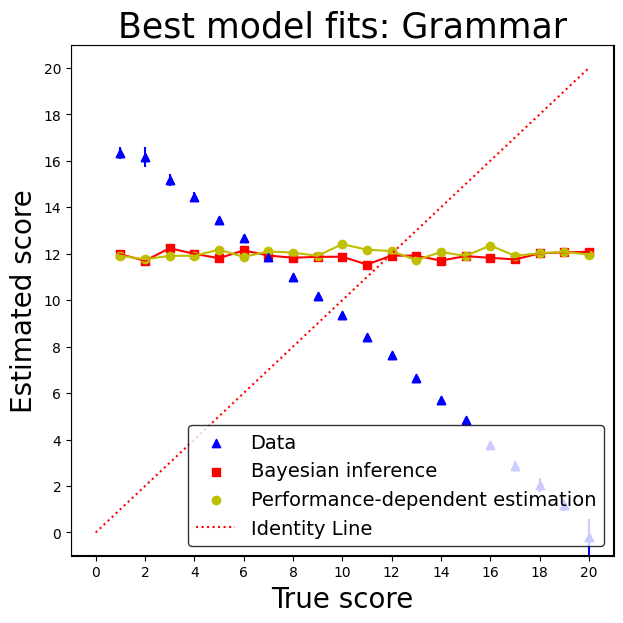

In [72]:
import warnings
plt.rcParams['text.usetex'] = False
warnings.filterwarnings("ignore")
# plot model predictions and data means - GUESS MODEL

k = gram.guess.groupby(gram.score).mean()
# k=k[:-1]
sems = gram.guess.groupby(gram.score).sem() # SEMs
# sems=sems[:-1]
conf = sems*1.96

score = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
# scoreNoZero = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]

fig, ax = plt.subplots()

# ax.scatter(scoreNoZero, k, label="data",marker='^')
#ax.scatter(data.score, data.absAssess1, label="data",marker='^')
ax.scatter(score, k, label="Data",color='b',marker='^')
ax.errorbar(score, k, conf,label="_nolegend_",fmt='^',color='b')
ax.plot(score, preds_guess[str(ssesG_ind)],color='r',label="_nolegend_")
ax.scatter(score, preds_guess[str(ssesG_ind)], label="Bayesian inference",color='r',marker='s')
ax.plot(score, preds_dk_guess[str(ssesGdk_ind)],color='y',label='_nolegend_')
ax.scatter(score, preds_dk_guess[str(ssesGdk_ind)], label="Performance-dependent estimation",color='y')


ax.set_facecolor('white')
plt.title('Best model fits: Grammar', fontsize=25)
plt.axhline(-1, color='black')
plt.axvline(-1, color='black')
plt.axhline(21, color='black')
plt.axvline(21, color='black')
ax.set_xlim(-1,21)
ax.set_ylim(-1,21)
ax.set_xticks(np.arange(0, 22, step=2))
ax.set_yticks(np.arange(0, 22, step=2))

ax.set_xlabel('True score',fontsize = 20)
ax.set_ylabel('Estimated score',fontsize = 20)
identity_line = ax.plot([0,5,10,15,20],[0,5,10,15,20], "r:",label='Identity Line')
legend = ax.legend(loc='lower right', prop={'size':14},frameon=True,facecolor='w',edgecolor='k')

fig.set_size_inches(7,7)
# ax.set_aspect('equal', 'box-forced')

plt.gcf().subplots_adjust(bottom=0.15)

plt.show()
# Please ignore wornings as these are font warnings which changes on system